In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install optuna
!pip install catboost

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import chi2_contingency, spearmanr, skew, pearsonr
from sklearn.metrics import r2_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import ParameterGrid
from sklearn.neighbors import KNeighborsClassifier

#SMOTE
from imblearn.over_sampling import SMOTE

#Mô hình XG Boost
import xgboost as xgb
from xgboost import plot_importance
from sklearn.model_selection import RandomizedSearchCV

#Random Forest
from sklearn.ensemble import RandomForestClassifier

import joblib

import optuna
from optuna.samplers import TPESampler
import catboost

In [4]:
data = pd.read_csv('/content/drive/MyDrive/Datasets/Diabetes 130 US hospitals for years (1999-2008)/diabetic_data.csv')
data

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,443847548,100162476,AfricanAmerican,Male,[70-80),?,1,3,7,3,...,No,Down,No,No,No,No,No,Ch,Yes,>30
101762,443847782,74694222,AfricanAmerican,Female,[80-90),?,1,4,5,5,...,No,Steady,No,No,No,No,No,No,Yes,NO
101763,443854148,41088789,Caucasian,Male,[70-80),?,1,1,7,1,...,No,Down,No,No,No,No,No,Ch,Yes,NO
101764,443857166,31693671,Caucasian,Female,[80-90),?,2,3,7,10,...,No,Up,No,No,No,No,No,Ch,Yes,NO


#I.PREPROCESSING

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

***Xử lý các giá trị Null, giá trị thiếu (?) trong dữ liệu bằng cách xóa hoặc bổ sung***

In [5]:
#Chuyển đôỉ các giá trị Không rõ ràng thành NaN:
def change_null(data):
  #Xóa bớt đi một số columns có giá trị rỗng quá nhiều:
  data = data.drop(columns = ['A1Cresult', 'max_glu_serum', 'medical_specialty', 'payer_code', 'weight'])

  # Thay thế tất cả các giá trị '?' trong toàn bộ databằng NaN
  data.replace('?', np.nan, inplace=True)

  #Tính toán các giá trị Race dựa trên việc tính xác suất race của các nhóm "age" và "gender"
  data['gender'] = data['gender'].replace('Unknown/Invalid', np.nan)
  most_frequent_race = data.groupby(["age","gender"])["race"].agg(lambda x: x.value_counts().index[0])
  data["race"] = data["race"].fillna(data.groupby(["age","gender"])["race"].transform(lambda x: x.value_counts().index[0]))

  data = data.dropna()
  return data

data = change_null(data)

***Tạo thêm một số columns mới để theo dõi sự biến thiên của các đặc trưng:***

*-Tạo 1 column tính toán tổng số dịch vụ sử dụng ('number_outpatient', 'number_emergency', 'number_inpatient')*

*-Tạo 1 columns để tính toán tổng của 23 loại thuốc, nếu giá trị là "no" hoặc "steady" thì giữ nguyên (0), còn nếu là "up" hoặc "down" thì cộng 1*

In [6]:
#23 giá trị thuốc bao gồm:
medical_cols = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide',
                'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'insulin', 'glyburide-metformin',
                'tolazamide', 'examide', 'citoglipton', 'metformin-pioglitazone', 'metformin-rosiglitazone',
                'glimepiride-pioglitazone', 'glipizide-metformin', 'troglitazone', 'tolbutamide', 'acetohexamide']

for i in medical_cols:
    data[i] = data[i].replace({'No': 0, 'Steady': 1, 'Up': 1, 'Down': 1})

# Tính tổng của các cột và lưu vào cột 'numchange'
#data['numchange'] = data[medical_cols].sum(axis=1)

***Tiếp theo encoding cho một số columns:***

In [7]:
def mapping_dataframe(data, column_names=['admission_type_id', 'discharge_disposition_id','admission_source_id',
                                          'change', 'gender', 'diabetesMed', 'age', 'race', 'readmitted']):

  admission_type_mapping = {2: 1, 7: 1, 6: 5, 8: 5}

  discharge_disposition_mapping = {6: 1, 8: 1, 9: 1, 13: 1, 3: 2, 4: 2, 5: 2, 14: 2, 22: 2, 23: 2, 24: 2, 12: 10, 15: 10, 16: 10, 17: 10, 25: 18, 26: 18}

  admission_source_mapping = {2: 1, 3: 1, 5: 4, 6: 4, 10: 4, 22: 4, 25: 4, 15: 9, 17: 9, 20: 9, 21: 9, 13: 11, 14: 11}

  change_mapping = {'Ch': 1, 'No': 0}

  gender_mapping = {'Male': 1, 'Female': 0}

  diabetesMed_mapping = {'Yes': 1, 'No': 0}

  age_mapping = {'[70-80)': 7, '[60-70)': 6, '[50-60)': 5, '[80-90)': 8, '[40-50)': 4, '[30-40)': 3, '[90-100)': 9, '[20-30)': 2, '[10-20)': 1, '[0-10)': 0}

  race_mapping = {'Other': 0, 'Caucasian': 4, 'AfricanAmerican': 3, 'Hispanic': 2, 'Asian': 1}

  readmitted_mapping = {'NO': 0, '<30': 1, '>30': 0}

  mappings = { 'admission_type_id': admission_type_mapping, 'discharge_disposition_id': discharge_disposition_mapping,
              'admission_source_id': admission_source_mapping, 'change': change_mapping, 'gender': gender_mapping,
               'diabetesMed': diabetesMed_mapping, 'age': age_mapping, 'race': race_mapping, 'readmitted': readmitted_mapping}

  for column in column_names:
    if column in data.columns and column in mappings:
      data[column] = data[column].replace(mappings[column])

  return data

data = mapping_dataframe(data)

***Cuối cùng, encoding cho 3 columns là diag_1, 2, 3***

In [8]:
diag_cols = ['diag_1', 'diag_2', 'diag_3']

for i in diag_cols:
    data[i] = data[i].fillna('')  # Thay thế NaN bằng chuỗi rỗng
    data.loc[data[i].str.contains('V', na=False), i] = 0
    data.loc[data[i].str.contains('E', na=False), i] = 0
    data[i] = pd.to_numeric(data[i], errors='coerce')
    data[i] = data[i].astype(np.float64)

In [9]:
#Ánh xạ các giá trị của 3 cols diag thành các giá trị ICD-9:
def map_diag_value(value):
    if value == 0:
        return value
    elif 1 <= value <= 139:
        return 1
    elif 140 <= value <= 239:
        return 2
    elif 240 <= value <= 279:
        return 3
    elif 280 <= value <= 289:
        return 4
    elif 290 <= value <= 319:
        return 5
    elif 320 <= value <= 389:
        return 6
    elif 390 <= value <= 459:
        return 7
    elif 460 <= value <= 519:
        return 8
    elif 520 <= value <= 579:
        return 9
    elif 580 <= value <= 629:
        return 10
    elif 630 <= value <= 679:
        return 11
    elif 680 <= value <= 709:
        return 12
    elif 710 <= value <= 739:
        return 13
    elif 740 <= value <= 759:
        return 14
    elif 760 <= value <= 779:
        return 15
    elif 780 <= value <= 799:
        return 16
    elif 800 <= value <= 999:
        return 17
# Áp dụng hàm cho cột 'diag_1, 2, 3':
for i in diag_cols:
  data[i] = data[i].apply(map_diag_value)

#CHUYỂN SANG DỮ LIỆU MỚI

**--------------------------------------------------------------------------------------------------------------------------------------------------------------**

***Dựa vào 'patient_nbr', ta sẽ loại bỏ đi các trường hợp trùng lặp***

In [10]:
df = data.drop_duplicates(subset= ['patient_nbr'], keep = 'first')
df

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
1,149190,55629189,4,0,1,1,1,7,3,59,...,0,1,0,0,0,0,0,1,1,0
2,64410,86047875,3,0,2,1,1,7,2,11,...,0,0,0,0,0,0,0,0,1,0
3,500364,82442376,4,1,3,1,1,7,2,44,...,0,1,0,0,0,0,0,1,1,0
4,16680,42519267,4,1,4,1,1,7,1,51,...,0,1,0,0,0,0,0,1,1,0
5,35754,82637451,4,1,5,1,1,1,3,31,...,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101754,443842016,183087545,4,0,7,1,1,7,9,50,...,0,1,0,0,0,0,0,1,1,0
101755,443842022,188574944,0,0,4,1,1,7,14,73,...,0,1,0,0,0,0,0,1,1,0
101756,443842070,140199494,0,0,6,1,1,7,2,46,...,0,1,0,0,0,0,0,0,1,0
101758,443842340,120975314,4,0,8,1,1,7,5,76,...,0,1,0,0,0,0,0,1,1,0


***FEATURES SELECTION***

***1.Pearson Correlation để kiểm tra tuyến tính***

In [11]:
pearson_cols = df.columns.drop(['readmitted'])

for i in pearson_cols:
  corr, _ = pearsonr(df[i], df['readmitted'])
  print(f"Pearson Correlation of column {i}:", corr)

Pearson Correlation of column encounter_id: -0.04939797416440103
Pearson Correlation of column patient_nbr: 0.0029185200725818806
Pearson Correlation of column race: 0.012352209312477935
Pearson Correlation of column gender: -0.0026220980208887445
Pearson Correlation of column age: 0.0391576406190387
Pearson Correlation of column admission_type_id: -0.0013209672602889216
Pearson Correlation of column discharge_disposition_id: 0.011394512460915128
Pearson Correlation of column admission_source_id: 0.007002419842354984
Pearson Correlation of column time_in_hospital: 0.05207652240346209
Pearson Correlation of column num_lab_procedures: 0.027823010905000688
Pearson Correlation of column num_procedures: -0.0027826958487119076
Pearson Correlation of column num_medications: 0.03201592626595219
Pearson Correlation of column number_outpatient: 0.00828222828812611
Pearson Correlation of column number_emergency: 0.028277376770579357
Pearson Correlation of column number_inpatient: 0.09945863226465

<ipython-input-11-067d9acca916>:4: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(df[i], df['readmitted'])


***2.Kiểm định Chi-squared cho các columns biến phân loại***

In [12]:
obj_cols = ["race","gender","age","admission_type_id","discharge_disposition_id","admission_source_id",
            "diag_1","diag_2","diag_3","metformin","repaglinide","nateglinide","chlorpropamide",
            "glimepiride","acetohexamide","glipizide","glyburide","tolbutamide","pioglitazone",
            "rosiglitazone","acarbose","miglitol","troglitazone","tolazamide","examide","citoglipton",
            "insulin","glyburide-metformin","glipizide-metformin","glimepiride-pioglitazone",
            "metformin-rosiglitazone","metformin-pioglitazone","change","diabetesMed"]

remove_obj_cols =[]

#Chi-square test cho các cột Object so với cột Output của data
for i in obj_cols:
  chi2, pval, _, _ = chi2_contingency(pd.crosstab(df[i], df['readmitted']))
  print(i, '---', pval)
  if pval > 0.05:
    remove_obj_cols.append(i)
  else:
    continue
print(remove_obj_cols)

race --- 0.02136601221593016
gender --- 0.49491849343041905
age --- 3.367971593151372e-27
admission_type_id --- 0.03672328706465604
discharge_disposition_id --- 3.2483222899877067e-197
admission_source_id --- 0.23140224359321815
diag_1 --- 2.374739521251552e-22
diag_2 --- 6.994747297546599e-08
diag_3 --- 3.7030174777344134e-09
metformin --- 0.005999127593419245
repaglinide --- 0.00013368955127213215
nateglinide --- 0.3958214033181118
chlorpropamide --- 0.2539177576250486
glimepiride --- 0.6470659026316175
acetohexamide --- 1.0
glipizide --- 0.0043794654465829684
glyburide --- 0.13883671810743423
tolbutamide --- 0.88041272937618
pioglitazone --- 0.6616111974070416
rosiglitazone --- 0.6715485653981015
acarbose --- 0.42972032121976744
miglitol --- 0.8286479741381606
troglitazone --- 1.0
tolazamide --- 0.5125443291187979
examide --- 1.0
citoglipton --- 1.0
insulin --- 1.4285694266830966e-10
glyburide-metformin --- 0.5856602775167585
glipizide-metformin --- 0.8718888025146077
glimepiride-pi

In [13]:
df = df.drop(columns = remove_obj_cols)
df =df.drop(columns = ['encounter_id', 'patient_nbr'])

***3.Kiểm định Spearman cho các columns còn lại***

In [14]:
df_cols = df.columns.to_list()
spearman_cols = [col for col in df_cols if col not in obj_cols]

In [15]:
spearman_df = df[spearman_cols]
correlation_results = []

# Duyệt qua tất cả các cột trong DataFrame
for col in spearman_df.columns:
  if col == 'readmitted':
    continue
  else:
    if spearman_df[col].nunique() > 1:
      corr, p_value = spearmanr(spearman_df[col], spearman_df['readmitted'])
      correlation_results.append((col, corr, p_value))
    else:
        print(f"Cột {col} có giá trị không thay đổi và bị bỏ qua.")

# Chuyển kết quả thành DataFrame để dễ quan sát
correlation_df = pd.DataFrame(correlation_results, columns=['Feature', 'Spearman Correlation', 'p-value'])
correlation_df = correlation_df.sort_values(by='Spearman Correlation', ascending=False)
correlation_df

,Feature,Spearman Correlation,p-value
6,number_inpatient,0.083355,8.971452e-109
0,time_in_hospital,0.056386,1.085822e-50
3,num_medications,0.038103,4.770791e-24
7,number_diagnoses,0.035755,2.296390e-21
5,number_emergency,0.029729,3.013898e-15
1,num_lab_procedures,0.028309,5.767533e-14
4,number_outpatient,0.015956,2.292592e-05
2,num_procedures,0.000604,8.726711e-01


In [16]:
#Dễ thấy, column 'num_procedures' không có Spearman thấp và p-val khá cao, nên loại bỏ đi column này
df = df.drop(columns = ['num_procedures'])

***4.Correlation Matrix***

*Thông thường thì các giá trị corr > 0.50 sẽ được cân nhắc để loại, nhưng trường hợp này thì ta có thể cân nhắc để giữ lại cũng không sao*

In [17]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,race,age,admission_type_id,discharge_disposition_id,time_in_hospital,num_lab_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,metformin,repaglinide,glipizide,insulin,change,diabetesMed,readmitted
race,1.000000,0.132754,0.038135,-0.000791,0.009440,-0.008843,0.057087,0.041420,-0.013273,0.015803,0.003299,0.010918,-0.002632,0.073348,0.000740,-0.000214,-0.000882,-0.030852,-0.010534,-0.003120,0.012352
age,0.132754,1.000000,-0.009058,0.033194,0.117082,0.026769,0.031164,0.022821,-0.051041,0.010388,0.014996,0.053508,0.046323,0.208803,-0.069557,0.039631,0.047378,-0.078761,-0.041135,-0.021278,0.039158
admission_type_id,0.038135,-0.009058,1.000000,0.072861,-0.027309,-0.136083,0.114674,0.050100,-0.014169,0.024452,-0.005348,-0.007682,-0.002208,-0.108562,0.014278,-0.013416,0.010619,-0.045200,-0.001820,-0.009621,-0.001321
discharge_disposition_id,-0.000791,0.033194,0.072861,1.000000,0.058619,0.019692,0.020559,-0.037213,-0.032741,-0.035299,-0.002452,-0.005027,0.001439,-0.033817,-0.018722,-0.016125,-0.026528,-0.086310,-0.054811,-0.059419,0.011395
time_in_hospital,0.009440,0.117082,-0.027309,0.058619,1.000000,0.330727,0.467016,-0.016754,-0.010317,0.061947,-0.134117,0.070403,0.091658,0.222913,-0.003945,0.030831,0.020844,0.110883,0.113604,0.071103,0.052077
num_lab_procedures,-0.008843,0.026769,-0.136083,0.019692,0.330727,1.000000,0.263074,-0.007460,0.013644,0.077977,-0.073090,0.013432,0.046804,0.156011,-0.045891,0.005922,0.023096,0.107851,0.074806,0.043639,0.027823
num_medications,0.057087,0.031164,0.114674,0.020559,0.467016,0.263074,1.000000,0.024131,0.000984,0.033975,-0.012446,0.067860,0.070113,0.240400,0.079365,0.023489,0.062087,0.212848,0.248057,0.192327,0.032016
number_outpatient,0.041420,0.022821,0.050100,-0.037213,-0.016754,-0.007460,0.024131,1.000000,0.094903,0.068267,-0.005346,0.009468,0.012941,0.074552,0.002788,-0.003361,0.014329,0.003854,0.023402,0.025192,0.008282
number_emergency,-0.013273,-0.051041,-0.014169,-0.032741,-0.010317,0.013644,0.000984,0.094903,1.000000,0.147349,0.000414,-0.004249,0.005071,0.049072,-0.003596,0.006287,-0.001730,0.035259,0.028440,0.029132,0.028277
number_inpatient,0.015803,0.010388,0.024452,-0.035299,0.061947,0.077977,0.033975,0.068267,0.147349,1.000000,-0.033633,0.002919,0.001620,0.062508,-0.041169,0.006681,0.005706,0.036770,0.003829,0.026389,0.099459


***Ở phần code mẫu, các columns của dataframe là: 'num_lab_procedures', 'num_medications', 'diag_3', 'diag_1', 'age', 'diag_2', 'time_in_hospital', 'number_diagnoses', 'num_procedures', 'admission_source_id', 'race', 'admission_type_id', 'discharge_disposition_id', 'insulin', 'diabetesMed', 'change', 'metformin', 'glipizide', 'number_outpatient', 'glyburide', 'rosiglitazone', 'pioglitazone', 'number_inpatient', 'glimepiride', 'number_emergency'***

In [18]:
df.columns

Index(['race', 'age', 'admission_type_id', 'discharge_disposition_id',
       'time_in_hospital', 'num_lab_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'metformin', 'repaglinide',
       'glipizide', 'insulin', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

In [19]:
df

,race,age,admission_type_id,discharge_disposition_id,time_in_hospital,num_lab_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,...,diag_2,diag_3,number_diagnoses,metformin,repaglinide,glipizide,insulin,change,diabetesMed,readmitted
1,4,1,1,1,3,59,18,0,0,0,...,3.0,3.0,9,0,0,0,1,1,1,0
2,3,2,1,1,2,11,13,2,0,1,...,3.0,0.0,6,0,0,1,0,0,1,0
3,4,3,1,1,2,44,16,0,0,0,...,3.0,7.0,7,0,0,0,1,1,1,0
4,4,4,1,1,1,51,8,0,0,0,...,2.0,3.0,5,0,0,1,1,1,1,0
5,4,5,1,1,3,31,16,0,0,0,...,7.0,3.0,9,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101754,4,7,1,1,9,50,33,0,0,0,...,9.0,3.0,9,0,0,0,1,1,1,0
101755,0,4,1,1,14,73,26,0,1,0,...,10.0,8.0,9,0,0,1,1,1,1,0
101756,0,6,1,1,2,46,17,1,1,1,...,10.0,7.0,9,0,0,0,1,0,1,0
101758,4,8,1,1,5,76,22,0,1,0,...,1.0,5.0,9,0,0,0,1,1,1,0


#PREDICTION

In [20]:
#Hàm đánh giá hiệu suất
def print_scores(y_test, y_pred):
  print(classification_report(y_test, y_pred))

#Hàm chia tập train-test và MinMax Scaler
def preprocess_data(data, test_size=0.2, random_state=42):

    # Chia tập train-test
    X = data.drop(columns=['readmitted'], axis=1)
    features = X.columns

    y = data['readmitted']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    #Standard Scaler
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    return X_train, X_test, y_train, y_test

In [21]:
X_train, X_test, y_train, y_test = preprocess_data(df)

***1.Random Forest và XG Boost thuần túy***

*Không được, gần như không có hiệu quả*

In [24]:
model_RF = RandomForestClassifier(n_estimators=200, random_state=42)
model_RF.fit(X_train, y_train)

y_train_pred = model_RF.predict(X_train)
y_test_pred = model_RF.predict(X_test)

print_scores(y_train, y_train_pred)
print_scores(y_test, y_test_pred)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     51328
           1       1.00      1.00      1.00      5002

    accuracy                           1.00     56330
   macro avg       1.00      1.00      1.00     56330
weighted avg       1.00      1.00      1.00     56330

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     12835
           1       0.67      0.00      0.00      1248

    accuracy                           0.91     14083
   macro avg       0.79      0.50      0.48     14083
weighted avg       0.89      0.91      0.87     14083



In [25]:
model_XGB = xgb.XGBClassifier(n_estimators=200, random_state=42)
model_XGB.fit(X_train, y_train)

y_train_pred = model_XGB.predict(X_train)
y_test_pred = model_XGB.predict(X_test)

print_scores(y_train, y_train_pred)
print_scores(y_test, y_test_pred)

              precision    recall  f1-score   support

           0       0.93      1.00      0.96     51328
           1       0.99      0.18      0.30      5002

    accuracy                           0.93     56330
   macro avg       0.96      0.59      0.63     56330
weighted avg       0.93      0.93      0.90     56330

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     12835
           1       0.27      0.01      0.03      1248

    accuracy                           0.91     14083
   macro avg       0.59      0.51      0.49     14083
weighted avg       0.86      0.91      0.87     14083



***1.CatBoostClassifier***

In [26]:
# Áp dụng SMOTE để tăng cường lớp 1
class_counts = y_train.value_counts()
smote = SMOTE(sampling_strategy={1: class_counts[0]}, random_state=42)
X_train_resample, y_train_resample = smote.fit_resample(X_train, y_train)

In [27]:
#Chia lại tập train và test
X_train, X_test, y_train, y_test = train_test_split(X_train_resample, y_train_resample, test_size=0.2, random_state=42)

In [28]:
def objective(trial):
    model = catboost.CatBoostClassifier(
        iterations=trial.suggest_int("iterations", 100, 1000),
        learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        depth=trial.suggest_int("depth", 4, 10),
        boosting_type= trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        bootstrap_type=trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "MVS"]
        ),
        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        random_strength=trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        bagging_temperature=trial.suggest_float("bagging_temperature", 0.0, 10.0),
        od_type=trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        od_wait=trial.suggest_int("od_wait", 10, 50),
        min_data_in_leaf=trial.suggest_int("min_data_in_leaf",51,120),
        loss_function='Logloss',
        eval_metric='Logloss',
        task_type='GPU',
        verbose=False,
    )
    model.fit(X_train, y_train,eval_set=[(X_test,y_test)])
    y_pred = model.predict(X_test)
    return f1_score(y_test, y_pred,average='micro')

In [30]:
params = {'iterations': 881, 'learning_rate': 0.01961057467284439, 'depth': 10, 'l2_leaf_reg': 0.0026174150623770134,
        'bootstrap_type': 'Bayesian', 'random_strength': 2.191236365450965e-06, 'bagging_temperature': 5.6475486877966965,
        'od_type': 'IncToDec', 'od_wait': 42}

In [31]:
model_CB = catboost.CatBoostClassifier(**params,verbose=False)
model_CB.fit(X_train,y_train)

probs = model_CB.predict_proba(X_test)
y_train_pred = model_CB.predict(X_train)
y_test_pred = model_CB.predict(X_test)

print(probs)
print(classification_report(y_train, y_train_pred))
print(classification_report(y_test, y_test_pred))

[[0.94742869 0.05257131]
 [0.99705572 0.00294428]
 [0.0067354  0.9932646 ]
 ...
 [0.03139536 0.96860464]
 [0.00613932 0.99386068]
 [0.97631282 0.02368718]]
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     41047
           1       1.00      0.94      0.97     41077

    accuracy                           0.97     82124
   macro avg       0.97      0.97      0.97     82124
weighted avg       0.97      0.97      0.97     82124

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     10281
           1       1.00      0.90      0.95     10251

    accuracy                           0.95     20532
   macro avg       0.95      0.95      0.95     20532
weighted avg       0.95      0.95      0.95     20532



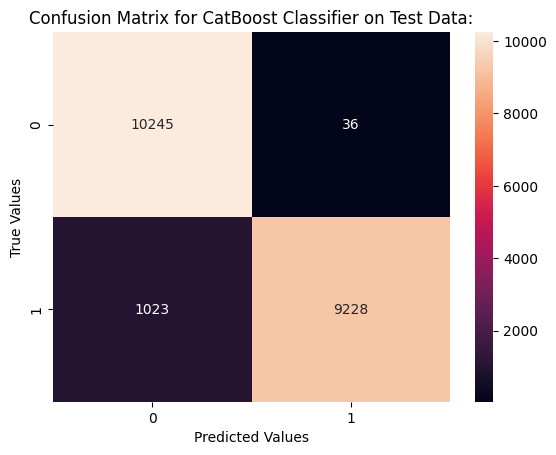

In [32]:
conf_matrix = confusion_matrix(y_test, y_test_pred)
sns.heatmap(conf_matrix, xticklabels=["0", "1"], yticklabels=["0", "1"], annot=True, fmt="d")
plt.title(f"Confusion Matrix for CatBoost Classifier on Test Data:")
plt.xlabel("Predicted Values")
plt.ylabel("True Values")
plt.show()